# Load Data

In [1]:
import pandas as pd 
from IPython.display import display

# Load dan merge data
df_train = pd.read_csv('train.csv', dtype={'StateHoliday': str})
store = pd.read_csv('store.csv')
df = pd.merge(df_train, store, on='Store', how='left')
# Replace NaN values with 'None' in string columns
df = df.fillna(0)

# Ambil semua data untuk Store 2
store_2_df = df[df['Store'] == 2].copy()

# Pastikan format datetime
store_2_df['Date'] = pd.to_datetime(store_2_df['Date'])

# Sort berdasarkan waktu
store_2_df = store_2_df.sort_values('Date')

# Filter hanya toko yang buka
store_2_df = store_2_df[store_2_df['Open'] == 1]

# Rename untuk Prophet
store_2_df = store_2_df.rename(columns={'Date': 'ds', 'Sales': 'y'})

# Drop rows dengan y = 0 (tidak terjadi penjualan meskipun toko buka)
store_2_df = store_2_df[store_2_df['y'] > 0]

# Reset index
store_2_df = store_2_df.reset_index(drop=True)

# Split 80-10-10
n = len(store_2_df)
train_end = int(0.8 * n)
val_end = int(0.9 * n)

train_df = store_2_df.iloc[:train_end].copy()
val_df = store_2_df.iloc[train_end:val_end].copy()
test_df = store_2_df.iloc[val_end:].copy()

# Cek ringkasan print
print(f"Train: {train_df['ds'].min()} - {train_df['ds'].max()} ({len(train_df)} rows)")
print(f"Val:   {val_df['ds'].min()} - {val_df['ds'].max()} ({len(val_df)} rows)")
print(f"Test:  {test_df['ds'].min()} - {test_df['ds'].max()} ({len(test_df)} rows)")


Train: 2013-01-02 00:00:00 - 2015-01-23 00:00:00 (627 rows)
Val:   2015-01-24 00:00:00 - 2015-04-27 00:00:00 (78 rows)
Test:  2015-04-28 00:00:00 - 2015-07-31 00:00:00 (79 rows)


# Check Outlier

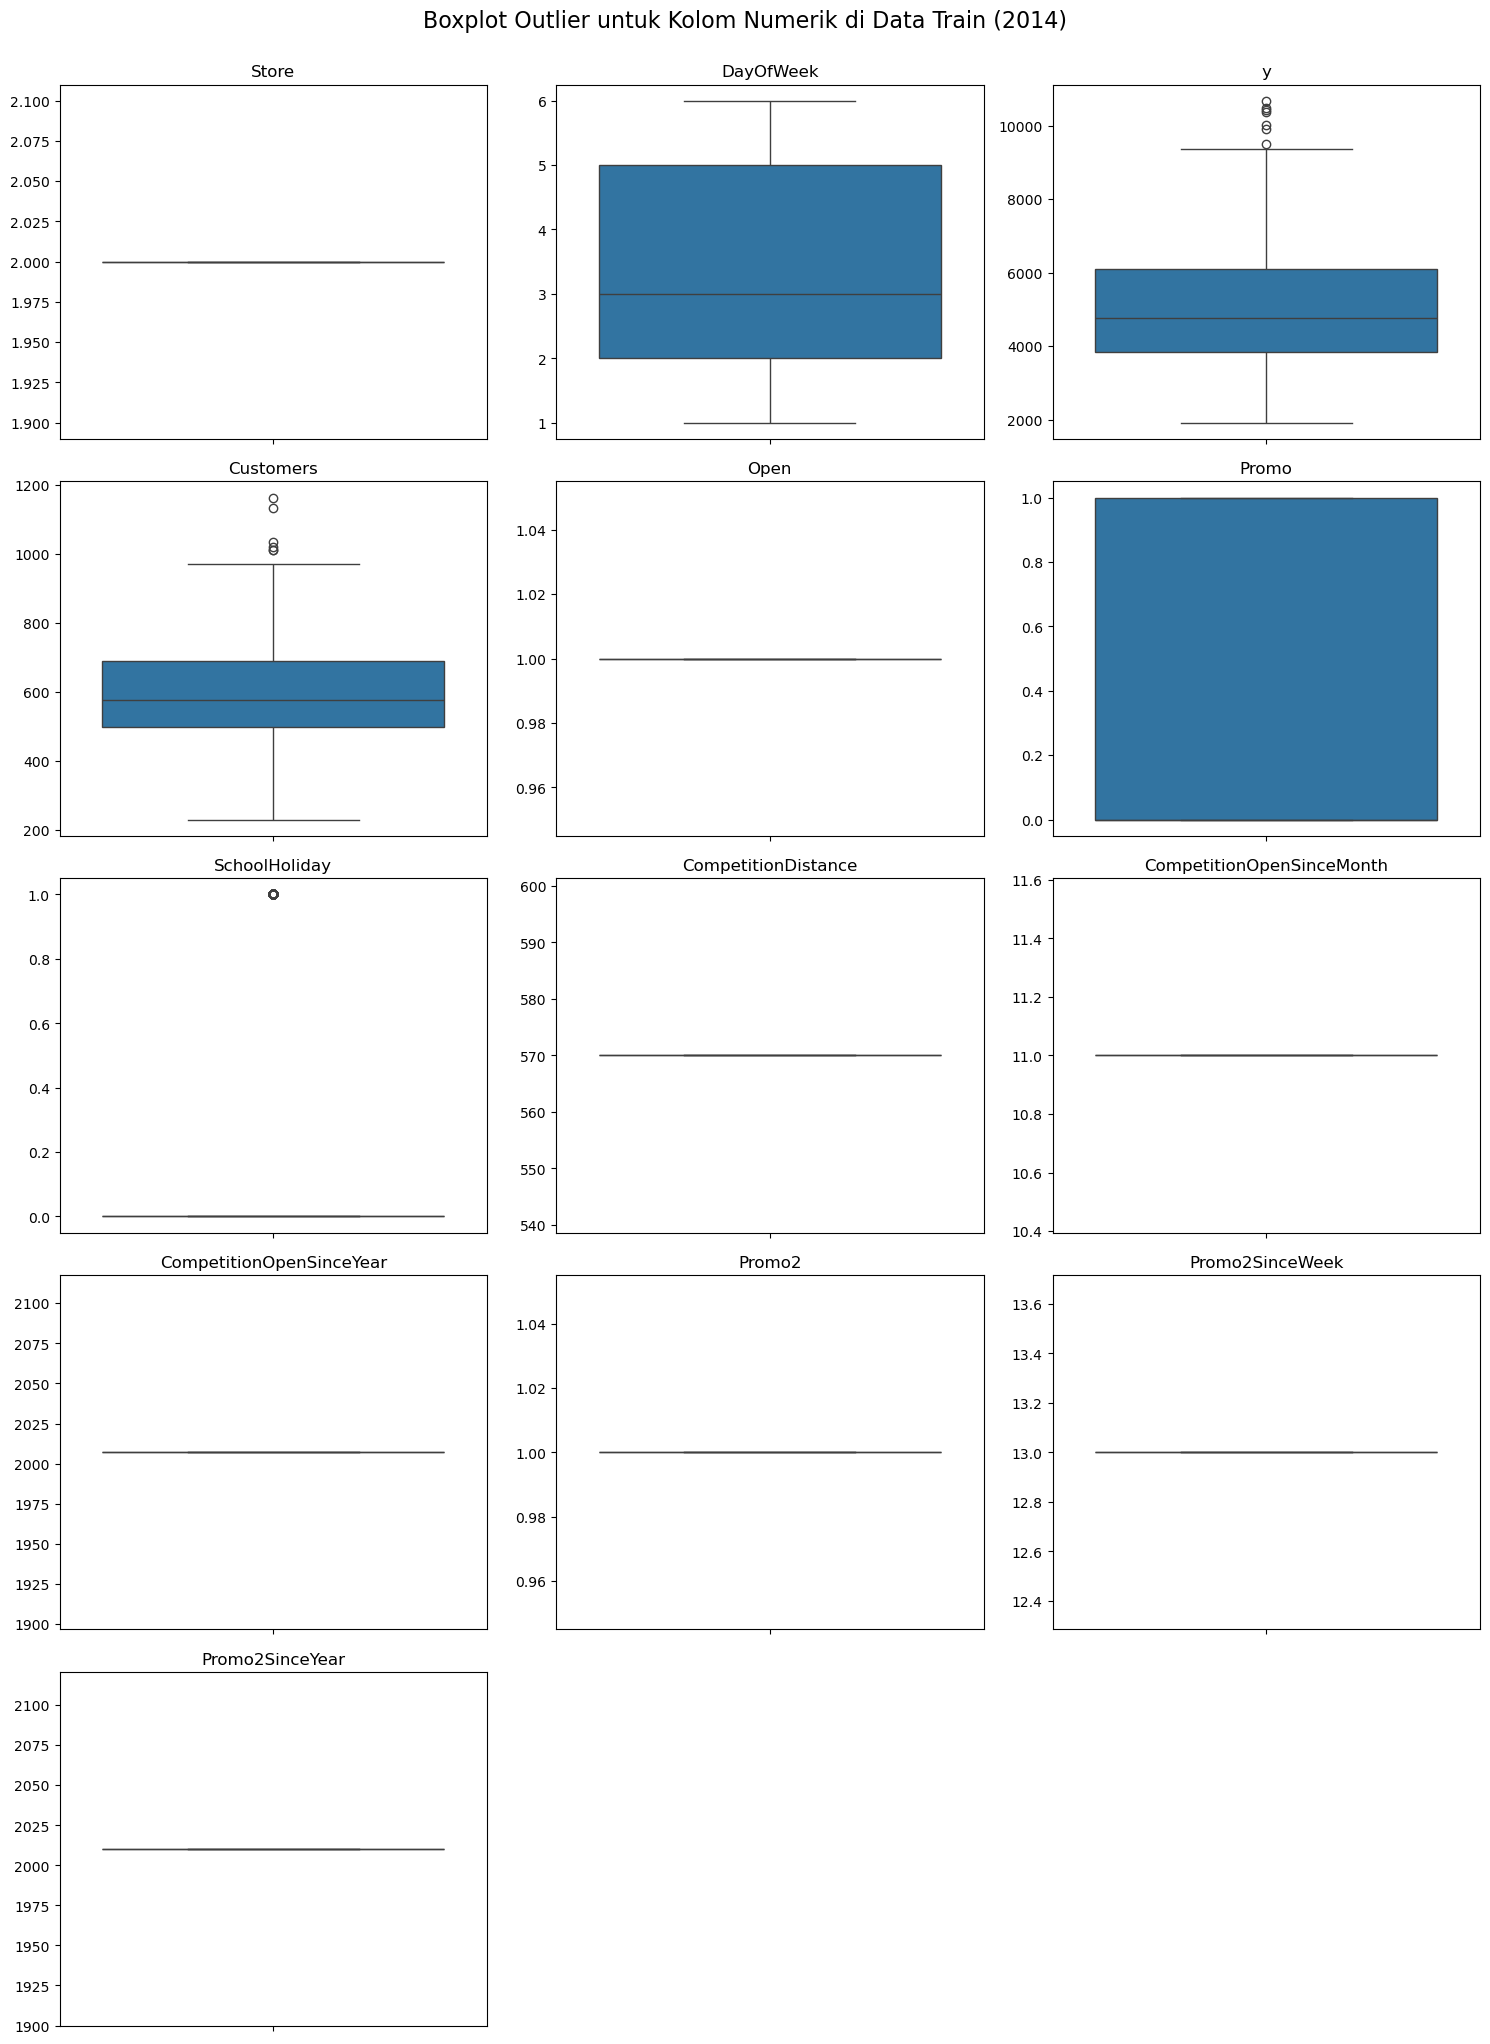

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pilih hanya kolom numerik dari train_df
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Setup subplot layout
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

# Buat boxplot untuk setiap kolom numerik
for i, col in enumerate(numeric_cols):
    sns.boxplot(y=train_df[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Hapus subplot kosong jika jumlah kolom tidak pas
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Atur layout dan judul
plt.tight_layout()
plt.suptitle("Boxplot Outlier untuk Kolom Numerik di Data Train (2014)", fontsize=16, y=1.02)
plt.show()


# Outlier Handling

In [3]:
import numpy as np
# Transform CompetitionDistance dengan log1p untuk semua subset
train_df['CompetitionDistance_log'] = np.log1p(train_df['CompetitionDistance'])
val_df['CompetitionDistance_log'] = np.log1p(val_df['CompetitionDistance'])
test_df['CompetitionDistance_log'] = np.log1p(test_df['CompetitionDistance'])


C:\Users\andre\AppData\Local\Temp\ipykernel_9068\1871058856.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['CompetitionDistance_log'] = np.log1p(train_df['CompetitionDistance'])
C:\Users\andre\AppData\Local\Temp\ipykernel_9068\1871058856.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['CompetitionDistance_log'] = np.log1p(val_df['CompetitionDistance'])
C:\Users\andre\AppData\Local\Temp\ipykernel_9068\1871058856.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

C:\Users\andre\AppData\Local\Temp\ipykernel_9068\1200778884.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Set'] = 'Train'
C:\Users\andre\AppData\Local\Temp\ipykernel_9068\1200778884.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['Set'] = 'Validation'
C:\Users\andre\AppData\Local\Temp\ipykernel_9068\1200778884.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

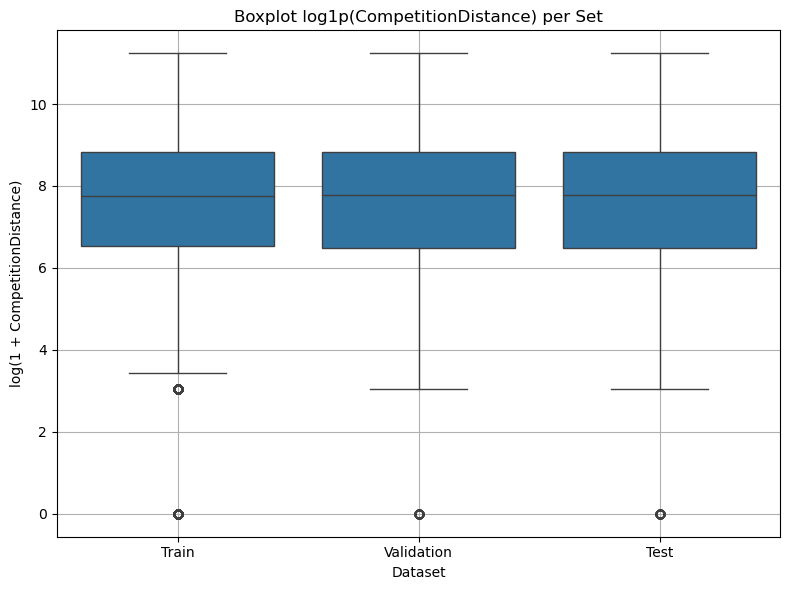

In [4]:
# Buat label set agar bisa digabung untuk visualisasi
train_df['Set'] = 'Train'
val_df['Set'] = 'Validation'
test_df['Set'] = 'Test'

# Gabungkan semua untuk plotting
df_combined = pd.concat([train_df, val_df, test_df])

# Buat boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Set', y='CompetitionDistance_log', data=df_combined)
plt.title('Boxplot log1p(CompetitionDistance) per Set')
plt.ylabel('log(1 + CompetitionDistance)')
plt.xlabel('Dataset')
plt.grid(True)
plt.tight_layout()
plt.show()

# Encoding

In [2]:
# Dalam bentuk DataFrame
dtypes_df = pd.DataFrame(train_df.dtypes, columns=['Data Type'])
display(dtypes_df)

train_df = train_df.drop(columns=['Set'], errors='ignore')
val_df = val_df.drop(columns=['Set'], errors='ignore')
test_df = test_df.drop(columns=['Set'], errors='ignore')



,Data Type
Store,int64
DayOfWeek,int64
ds,datetime64[ns]
y,int64
Customers,int64
Open,int64
Promo,int64
StateHoliday,object
SchoolHoliday,int64
StoreType,object


In [3]:
#one hot encoding
categorical_cols = ['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']

train_df_onehot = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)
dummy_cols = [col for col in train_df_onehot.columns if any(cat in col for cat in categorical_cols)]
train_df_onehot[dummy_cols] = train_df_onehot[dummy_cols].astype(int)


In [9]:
display(train_df_onehot.head(10))

,Store,DayOfWeek,ds,y,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,StateHoliday_a
0,2,3,2013-01-02,4422,650,1,0,1,570.0,11.0,2007.0,1,13.0,2010.0,0
1,2,4,2013-01-03,4159,555,1,0,1,570.0,11.0,2007.0,1,13.0,2010.0,0
2,2,5,2013-01-04,4484,574,1,0,1,570.0,11.0,2007.0,1,13.0,2010.0,0
3,2,6,2013-01-05,2342,324,1,0,0,570.0,11.0,2007.0,1,13.0,2010.0,0
4,2,1,2013-01-07,6775,763,1,1,0,570.0,11.0,2007.0,1,13.0,2010.0,0
5,2,2,2013-01-08,6318,685,1,1,0,570.0,11.0,2007.0,1,13.0,2010.0,0
6,2,3,2013-01-09,6763,785,1,1,0,570.0,11.0,2007.0,1,13.0,2010.0,0
7,2,4,2013-01-10,5618,637,1,1,0,570.0,11.0,2007.0,1,13.0,2010.0,0
8,2,5,2013-01-11,4810,539,1,1,0,570.0,11.0,2007.0,1,13.0,2010.0,0
9,2,6,2013-01-12,2630,337,1,0,0,570.0,11.0,2007.0,1,13.0,2010.0,0


In [5]:
# Buat satu set kolom target yang kita pakai dari train
target_columns = train_df_onehot.columns

# One-hot encode val dan test
val_df_onehot = pd.get_dummies(val_df, columns=categorical_cols, drop_first=True)
val_df_onehot = val_df_onehot.reindex(columns=target_columns, fill_value=0)

test_df_onehot = pd.get_dummies(test_df, columns=categorical_cols, drop_first=True)
test_df_onehot = test_df_onehot.reindex(columns=target_columns, fill_value=0)


In [6]:
train_df_onehot = train_df_onehot[train_df_onehot['Open'] == 1]
val_df_onehot = val_df_onehot[val_df_onehot['Open'] == 1]
test_df_onehot = test_df_onehot[test_df_onehot['Open'] == 1]

In [8]:
display(train_df_onehot.head(10))

,Store,DayOfWeek,ds,y,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,StateHoliday_a
0,2,3,2013-01-02,4422,650,1,0,1,570.0,11.0,2007.0,1,13.0,2010.0,0
1,2,4,2013-01-03,4159,555,1,0,1,570.0,11.0,2007.0,1,13.0,2010.0,0
2,2,5,2013-01-04,4484,574,1,0,1,570.0,11.0,2007.0,1,13.0,2010.0,0
3,2,6,2013-01-05,2342,324,1,0,0,570.0,11.0,2007.0,1,13.0,2010.0,0
4,2,1,2013-01-07,6775,763,1,1,0,570.0,11.0,2007.0,1,13.0,2010.0,0
5,2,2,2013-01-08,6318,685,1,1,0,570.0,11.0,2007.0,1,13.0,2010.0,0
6,2,3,2013-01-09,6763,785,1,1,0,570.0,11.0,2007.0,1,13.0,2010.0,0
7,2,4,2013-01-10,5618,637,1,1,0,570.0,11.0,2007.0,1,13.0,2010.0,0
8,2,5,2013-01-11,4810,539,1,1,0,570.0,11.0,2007.0,1,13.0,2010.0,0
9,2,6,2013-01-12,2630,337,1,0,0,570.0,11.0,2007.0,1,13.0,2010.0,0


In [7]:
display(train_df_onehot.columns)

Index(['Store', 'DayOfWeek', 'ds', 'y', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'StateHoliday_a'],
      dtype='object')

# Modelling(Prophet)

In [10]:
train_df_onehot = train_df_onehot.rename(columns={'Date': 'ds', 'Sales': 'y'})
val_df_onehot = val_df_onehot.rename(columns={'Date': 'ds', 'Sales': 'y'})
test_df_onehot = test_df_onehot.rename(columns={'Date': 'ds', 'Sales': 'y'})

In [11]:
all_regressors = [col for col in train_df_onehot.columns if col not in ['ds', 'y']]

In [12]:
from prophet import Prophet

model = Prophet()
for reg in all_regressors:
    model.add_regressor(reg)

model.fit(train_df_onehot[['ds', 'y'] + all_regressors])

20:26:19 - cmdstanpy - INFO - Chain [1] start processing
20:26:19 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
# Pastikan urutan kolom dan format sama
val_forecast = model.predict(val_df_onehot[['ds'] + all_regressors])

MAE  : 449.95
MAPE : 10.03%
R²   : 0.8854


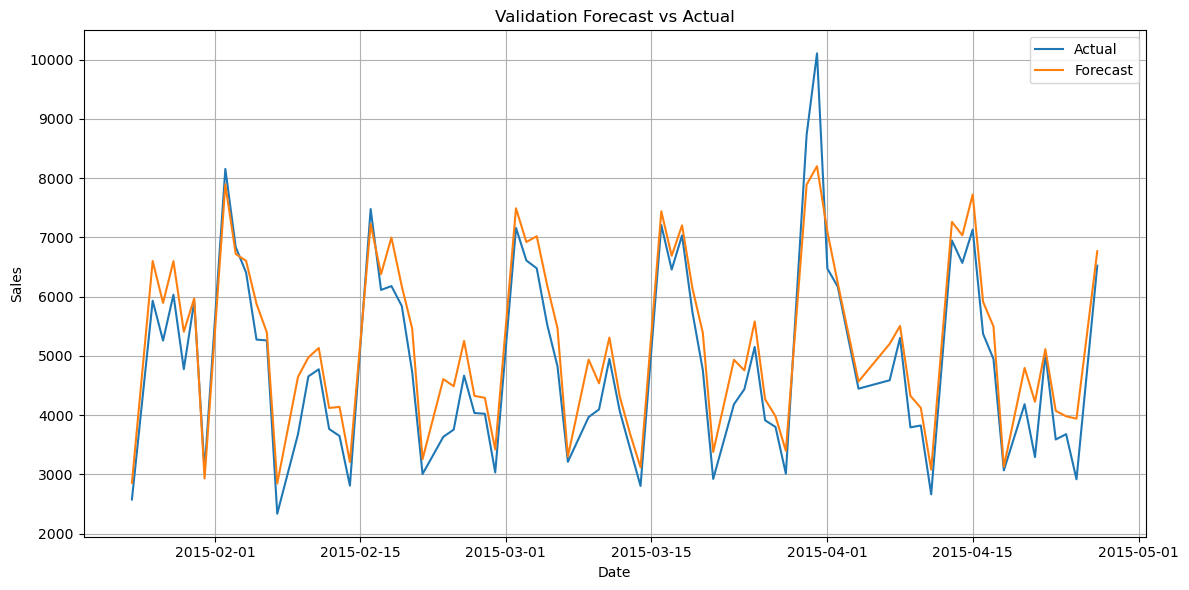

In [14]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

y_true = val_df_onehot['y']
y_pred = val_forecast['yhat']

mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE  : {mae:.2f}")
print(f"MAPE : {mape:.2%}")
print(f"R²   : {r2:.4f}")

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(val_df_onehot['ds'], y_true, label='Actual')
plt.plot(val_df_onehot['ds'], y_pred, label='Forecast')
plt.title("Validation Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
test_forecast = model.predict(test_df_onehot[['ds'] + all_regressors])


c:\Users\andre\anaconda3\envs\compvis\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\andre\anaconda3\envs\compvis\lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\andre\anaconda3\envs\compvis\lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarra

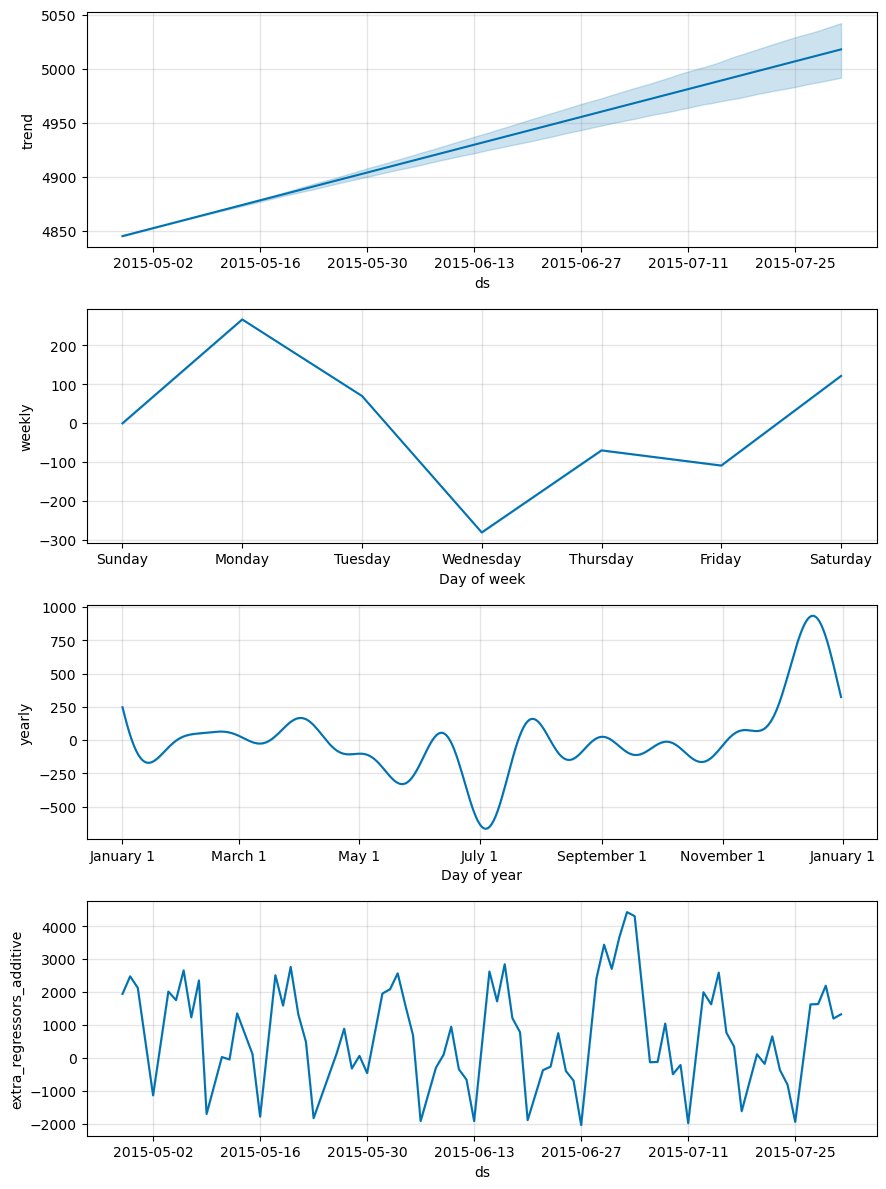

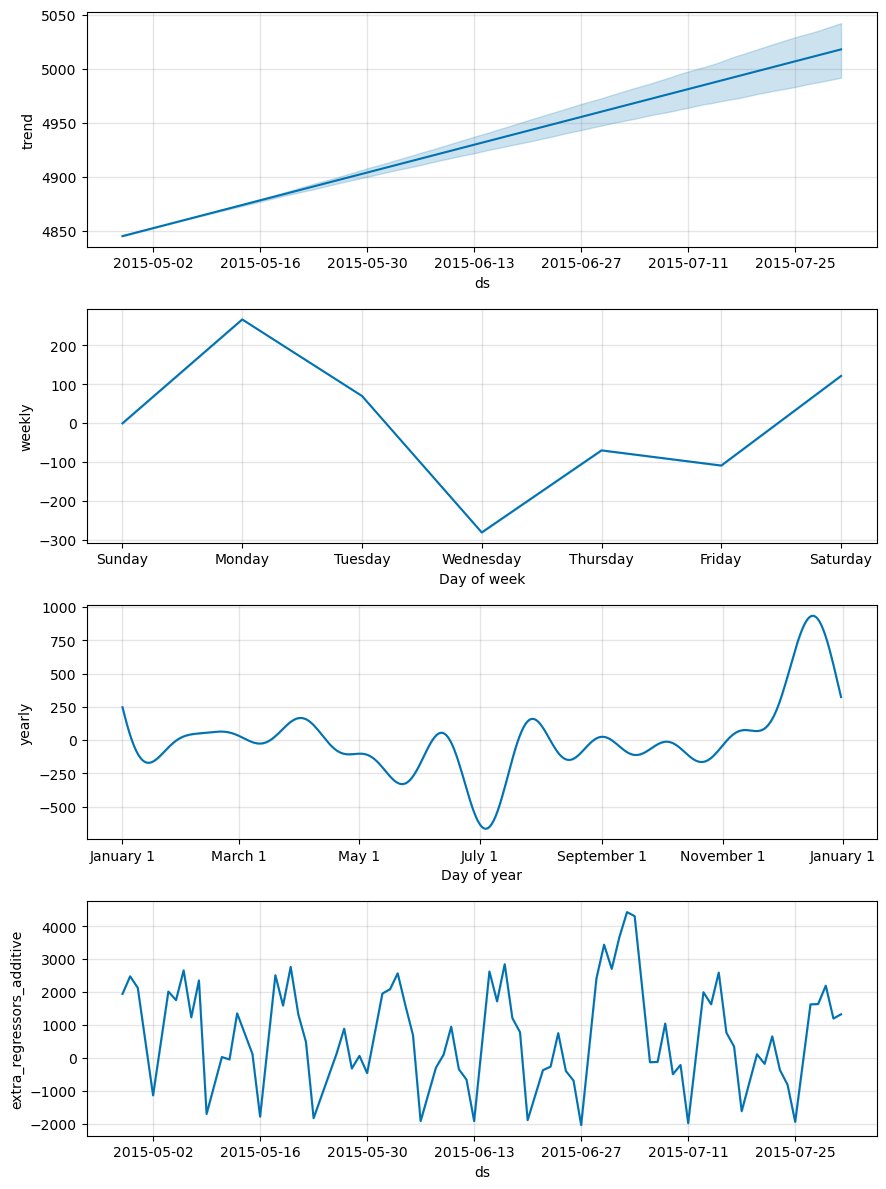

In [16]:
model.plot_components(test_forecast)